In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import itertools

from utilities2015 import DataManager, chi2s

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cPickle as pickle

from scipy.signal import fftconvolve

from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [2]:
import cv2

In [53]:
section_id = 101
dm = DataManager(stack='MD593', section=section_id)

In [54]:
texton_hists = dm.load_pipeline_result('texHist', 'npy')

segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = segmentation.max() + 1

textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = textonmap.max() + 1

In [55]:
thetas = np.linspace(-np.pi/8, np.pi/8, 3)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

scales = np.linspace(.8, 1.2, 3)
n_scales = len(scales)

# grid_spacing = (10,10)

In [56]:
labeling_name = 'MD593_0100_yuncong_09202015173615'
lm_ind = 3

b = time.time()
with open('/home/yuncong/csd395/CSHL_data_landmarks/%s_landmark_%d.pkl'%(labeling_name, lm_ind), 'r') as f:
    landmark_descriptor = pickle.load(f)
print 'load', time.time() - b

load 2.60519504547


In [57]:
n_variations = len(landmark_descriptor)

In [58]:
xc_mask, yc_mask = (landmark_descriptor[4]['centroid_global'] - (dm.xmin, dm.ymin)).astype(np.int)

roi_ymin = max(0, yc_mask-4000)
roi_ymax = min(dm.h, yc_mask+4000)
roi_xmin = max(0, xc_mask-4000)
roi_xmax = min(dm.w, xc_mask+4000)

textonmap_individual_channels = [textonmap[dm.ymin+roi_ymin:dm.ymin+roi_ymax+1,
                                           dm.xmin+roi_xmin:dm.xmin+roi_xmax+1] == c for c in range(n_texton)]

In [59]:
def convolve_roi(texton_ind, variation_ind, roi_xmin, roi_xmax, roi_ymin, roi_ymax):
    return fftconvolve(textonmap_individual_channels[texton_ind], 
                       landmark_descriptor[variation_ind]['mask'][::-1, ::-1], 
                       mode='same')

In [60]:
bbox = [None for _ in range(n_variations)]
vs = [None for _ in range(n_variations)]

for variation_ind in range(n_variations):
#     variation_ind = 4
    
    t = time.time()

    histograms = Parallel(n_jobs=8)(delayed(convolve_roi)(c, variation_ind, roi_xmin, roi_xmax, roi_ymin, roi_ymax) 
                                    for c in range(n_texton))
    histograms = np.rollaxis(np.asarray(histograms), 0, 3).astype(np.float)
    histograms = histograms / histograms.sum(axis=-1)[:,:,None]
    vs_flat = chi2s(landmark_descriptor[variation_ind]['hist'], histograms.reshape((-1,n_texton)))

    vsmat = vs_flat.reshape(histograms.shape[:2])
    v = np.exp(-vsmat/.5)

    offset_x, offset_y = landmark_descriptor[variation_ind]['centroid_local'] - \
                (landmark_descriptor[variation_ind]['width']/2, landmark_descriptor[variation_ind]['height']/2)
    
    bbox[variation_ind] = (dm.ymin+roi_ymin-offset_y, dm.ymin+roi_ymax-offset_y, 
                           dm.xmin+roi_xmin-offset_x, dm.xmin+roi_xmax-offset_x)
    vs[variation_ind] = v
    
    print time.time() - t

33.8782660961
40.8226001263
37.6223380566
36.1010959148
58.1824629307
43.3414330482
38.6902580261
38.0381469727
39.4790291786


In [ ]:
y,x = peaks_sorted[2]
vi = variations_sorted[2]

roi_ymin, roi_ymax, roi_xmin, roi_xmax = bbox[vi]
image_roi = dm.image[roi_ymin:roi_ymax, roi_xmin:roi_xmax]
score_overlay = plt.cm.jet(vs[vi]/vs[vi].max())[...,:3]

peak_viz = np.zeros(image_roi.shape + (4,), np.uint8)

cv2.ellipse(peak_viz, (x,y), 
            (int(2*1.5*landmark_descriptor[vi]['s1']), 
             int(2*1.5*landmark_descriptor[vi]['s2'])),
            int(landmark_descriptor[vi]['ellipse_angle']), 0, 360, (0,0,0,1), 10)

viz = alpha_blending(gray2rgb(image_roi), score_overlay, .6, .4)
viz = alpha_blending(viz[...,:3], peak_viz[...,:3], .5, peak_viz[...,-1])

In [218]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [86]:
from skimage.feature import peak_local_max
from skimage.util import img_as_ubyte

In [87]:
peaks = [peak_local_max(vs[variation_ind], min_distance=100, threshold_rel=.8) 
                   for variation_ind in range(n_variations)]

variation_inds = np.concatenate([variation_i * np.ones((ps.shape[0],), np.int) 
                                 for variation_i, ps in enumerate(peaks)])
peaks = np.vstack(peaks)

peak_scores = np.array([vs[vi][y, x] for vi, (y, x) in zip(variation_inds, peaks)])
peak_order = np.argsort(peak_scores)[::-1]
variations_sorted = variation_inds[peak_order]
peaks_sorted = peaks[peak_order]
peak_scores_sorted = peak_scores[peak_order]

In [88]:
dm._load_image(keep_rgb=False)

In [66]:
from utilities2015 import alpha_blending, display
from skimage.color import gray2rgb

In [90]:
for vi, (y, x), s in zip(variations_sorted, peaks_sorted, peak_scores_sorted)[0:1]:
    
    print vi, x, y, s
    
    roi_ymin, roi_ymax, roi_xmin, roi_xmax = bbox[vi]
    image_roi = dm.image[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]
    score_overlay = plt.cm.jet(vs[vi]/vs[vi].max())[...,:3]
    
    peak_viz = np.zeros(image_roi.shape + (4,), np.uint8)

    cv2.ellipse(peak_viz, (x,y), 
                (int(2*landmark_descriptor[vi]['s1']), 
                 int(2*landmark_descriptor[vi]['s2'])),
                int(landmark_descriptor[vi]['ellipse_angle']), 0, 360, (0,0,0,1), 10)
    
    viz = alpha_blending(gray2rgb(image_roi), score_overlay, .6, .4)
    viz = alpha_blending(viz[...,:3], peak_viz[...,:3], .5, peak_viz[...,-1])

4 4008 1518 1.0


In [108]:
landmark_descriptor[variation_ind]['centroid_local'] - \
                (landmark_descriptor[variation_ind]['width']/2, landmark_descriptor[variation_ind]['height']/2)

array([ -4.8425154 ,  12.61650527])

In [107]:
np.r_[4008,1518] + (roi_xmin, roi_ymin)

array([ 9286.8425154 ,  3377.38349473])

In [106]:
landmark_descriptor[4]['centroid_global']

array([ 9271.1574846 ,  3354.61650527])

In [93]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [31]:
def evaluate_spline_partial(spline, s):
    return spline(s, range(dm.image_height)) # indirect call is faster than directly put spline() in delayed; don't know why


def compute_filter_response_at_points2(pts, d):
    
    n = len(pts)
    
    vs = np.empty((n,), dtype=np.float)

    for i, (x, y) in enumerate(pts):

        masked_textons = textonmap[y+d['mask_ymin']:y+d['mask_ymax']+1, 
                                   x+d['mask_xmin']:x+d['mask_xmax']+1][d['mask']]        
        masked_texton_hist = np.bincount([i for i in masked_textons if i != -1], minlength=n_texton)
        masked_texton_hist = masked_texton_hist/float(masked_texton_hist.sum())
        vs[i] = chi2(masked_texton_hist, d['hist'])
        
    return vs

def filter_image_with_landmark_descriptor2(landmark_descriptor):
    
    for i, (theta_i, scale_i) in enumerate(itertools.product(range(n_theta), range(n_scales))):
#     for i, (theta_i, scale_i) in enumerate(itertools.product(range(1), range(1))):

        print 'theta', theta_i, 'scale', scale_i

        b = time.time()
        
        d = landmark_descriptor[i]
        centroid_global = d['centroid_global'].astype(np.int)
        
        ys, xs = np.mgrid[max(dm.ymin-d['mask_ymin'], centroid_global[1] - 100) : min(dm.ymax + 1 - d['mask_ymax'], centroid_global[1] + 100) : grid_spacing[1], 
                          max(dm.xmin-d['mask_xmin'], centroid_global[0] - 100) : min(dm.xmax + 1 - d['mask_xmax'], centroid_global[0] + 100) : grid_spacing[0]]
        
        pts = np.c_[xs.flat, ys.flat]        
        res =  Parallel(n_jobs=16)(delayed(compute_filter_response_at_points2)(s, d) 
                                   for s in np.array_split(pts, 16))
        

        print time.time() - b
    

In [30]:
q = filter_image_with_landmark_descriptor2(landmark_descriptor)

theta 0 scale 0
9.09901499748


In [ ]:
landmark_indices = range(17)
for lm_ind in landmark_indices:
    try:
        _ = filter_image_with_landmark_descriptor(lm_ind, labeling_name)
    except:
        pass

In [312]:
display(plt.cm.jet(vs_max_all_angles[4]/np.max(vs_max_all_angles[4])))

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

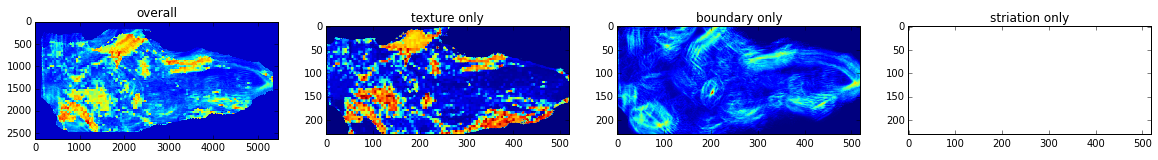

In [311]:
fig, axes = plt.subplots(1,4, figsize=(20,20))
axes[0].imshow(vs_max_all_angles[4]);
axes[0].set_title('overall');
axes[1].imshow(vs_texture_all_angles[4]);
axes[1].set_title('texture only');
axes[2].imshow(vs_boundary_all_angles[4]);
axes[2].set_title('boundary only');
axes[3].imshow(vs_striation_all_angles[4]);
axes[3].set_title('striation only');
# axes[3].imshow(Gmax);
# axes[3].set_title('edge prob. map');